## Analiza danych w zadanym formacie

dim, ts_name,     best_value,                 steps_to_best_value

np.

188, PPO_G2_130k, 158810.53550787075, 18135

Set-up

In [ ]:
# 1. IMPORTY I KONFIGURACJA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import glob
import os

MAKE_PLOTS_FOR_DETEMINISTICS = True
MAKE_PLOTS_FOR_HALF_STEPS = True
SHOW_PLOTS_FOR_HARDER_PROBLEM = False

plt.rcParams['figure.figsize'] = (10, 6)

# 2. Ścieżka do folderu z plikami
folder_path = "./"#Tests/FinalTests/"  # lub np. "./dane/"
if SHOW_PLOTS_FOR_HARDER_PROBLEM:
    pattern = os.path.join(folder_path, "sa_results_hard_half_stoch_*.csv")
elif MAKE_PLOTS_FOR_HALF_STEPS:
    if MAKE_PLOTS_FOR_DETEMINISTICS == True:
        pattern = os.path.join(folder_path, "sa_results_TSPLIB_det_*.csv")
    else:
        pattern = os.path.join(folder_path, "sa_results_TSPLIB_stoch_*.csv")
else: 
    folder_path = "./Tests/FinalTests"
    if MAKE_PLOTS_FOR_DETEMINISTICS == True:
        pattern = os.path.join(folder_path, "sa_results_det_*.csv")
    else:
        pattern = os.path.join(folder_path, "sa_results_stoch_*.csv")


# 3. Wczytywanie i łączenie danych
all_files = glob.glob(pattern)
df_list = []

for file in all_files:
    temp_df = pd.read_csv(file)
    #temp_df['source_file'] = os.path.basename(file)  # opcjonalnie: dodaj nazwę pliku jako kolumnę
    df_list.append(temp_df)

# 4. Łączenie w jeden DataFrame
df = pd.concat(df_list, ignore_index=True)


#df = df[~df["ts_name"].isin(['Const_100'])]
#df = df[df["dim"].isin(['brg180'])]
#df = df[df["dim"].isin(range(50,76))]

# 3. Krótkie „smoking‑gun”
display(df.head())
display(df.describe(include='all'))#165138.827656	

,dim,ts_name,best_value,steps_to_best_value
0,135,E,87194.145297,17735
1,135,F_2,88651.892613,11165
2,135,G,87813.985094,1235
3,135,G2,87885.505233,25745
4,135,G3_1,85993.054668,20965


,dim,ts_name,best_value,steps_to_best_value
count,241824.000000,241824,241824.000000,241824.000000
unique,NaN,24,NaN,NaN
top,NaN,E,NaN,NaN
freq,NaN,10076,NaN,NaN
mean,175.281461,NaN,166870.717946,19397.011153
std,72.473549,NaN,122723.824580,14699.232956
min,50.000000,NaN,8395.141970,0.000000
25%,113.000000,NaN,56560.985844,7685.000000
50%,176.000000,NaN,141696.662792,15515.000000
75%,238.000000,NaN,264515.604633,28702.250000


In [298]:
#Średnia, odchylenie standardowe, min i max dla 'best_value' i 'steps_to_best_value' w grupach ts_name
group_stats = df.groupby('ts_name')[['best_value', 'steps_to_best_value']].agg(['mean', 'std'])

# wykonanie różnicy a.x - PPO.x
baseline = group_stats.loc['Linear']
diff_stats = group_stats.subtract(baseline, axis='columns').multiply(-100,axis='columns').divide(baseline, axis='columns')

#ewentualne sortownia po zadanej kolumnie
#diff_stats = diff_stats.sort_values(('best_value', 'mean'), ascending=False)

# Wyświetlenie wyników
styled = diff_stats.style\
    .background_gradient(subset=[('best_value','mean'), ('steps_to_best_value','mean')], cmap='viridis')\
    .format("{:.4f}")

# Aby zobaczyć ją w notebooku:
styled

tabela przedstawia polepszenie lub pogorszenie w % względem wybranego typu sterowania

(x.mean - PPO.mean)/PPO.mean * 100

dodatnia wartość >> PPO_G2 bylo lepsze

ujemna wartość >> PPO_G2 bylo gorsze

C:\Users\piotr\AppData\Local\Temp\ipykernel_8184\3898975571.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=plot_data, x='dim', y='best_value', hue='ts_name', marker='o', ci=None) # ci=None if you don't want confidence intervals for single points


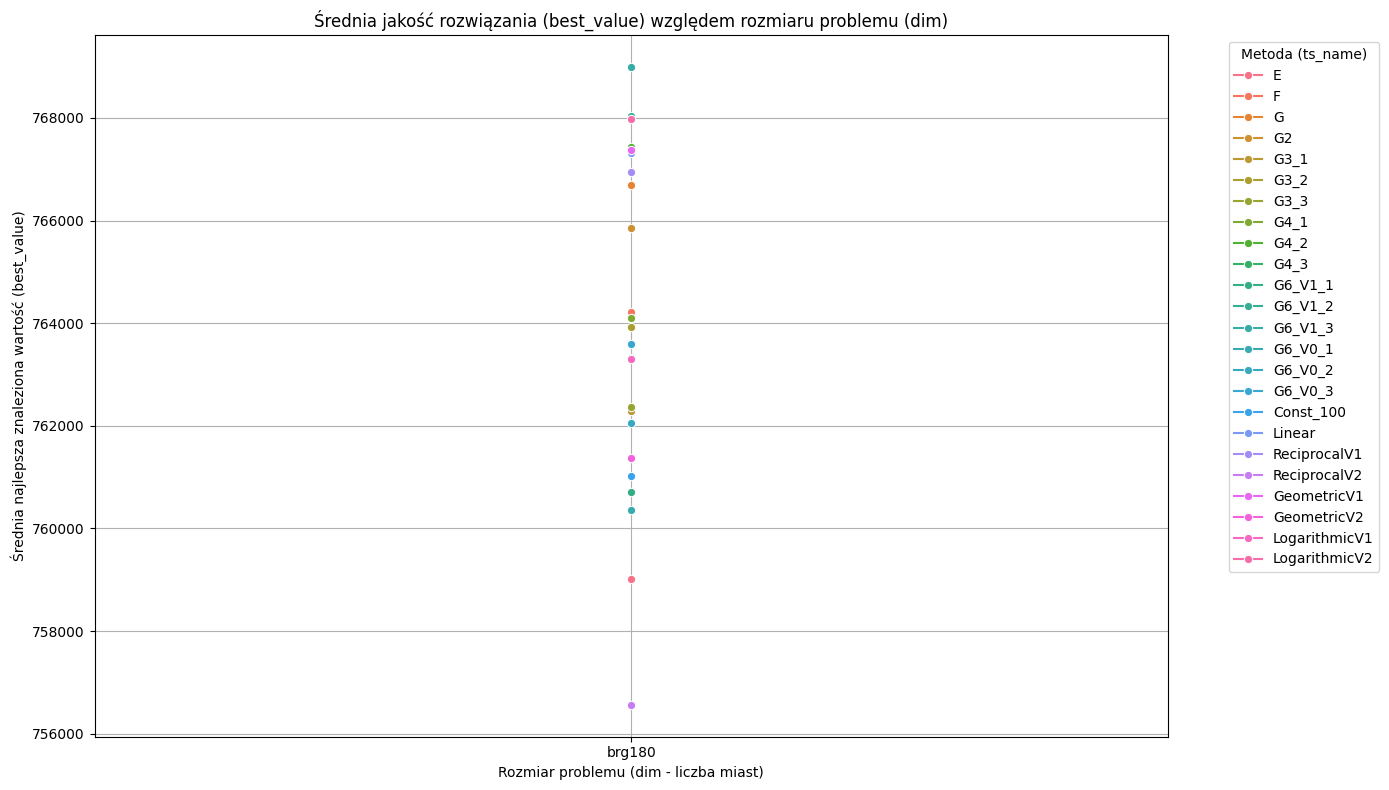

C:\Users\piotr\AppData\Local\Temp\ipykernel_8184\3898975571.py:56: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_relative_melted, x='dim', y='relative_performance_pct', hue='ts_name', marker='o', ci=None)


KeyboardInterrupt: 

In [289]:
plot_data = df.copy()


# Create the plot
plt.figure(figsize=(14, 8))
sns.lineplot(data=plot_data, x='dim', y='best_value', hue='ts_name', marker='o', ci=None) # ci=None if you don't want confidence intervals for single points

# Add titles and labels
plt.title('Średnia jakość rozwiązania (best_value) względem rozmiaru problemu (dim)')
plt.xlabel('Rozmiar problemu (dim - liczba miast)')
plt.ylabel('Średnia najlepsza znaleziona wartość (best_value)')
plt.legend(title='Metoda (ts_name)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout() # Adjust layout to make room for the legend

# Show the plot
plt.show()

# --- Alternative: Plotting relative performance (e.g., % difference from a baseline) ---
# This part is more complex if you want to show it on the same graph vs. problem size,
# as the baseline might change with problem size or you might pick one overall baseline method.

# Let's assume 'Linear' is our baseline for each 'dim'
# First, pivot the table to have ts_name as columns
df_pivot = df.pivot_table(index='dim', columns='ts_name', values='best_value')

# Define the baseline method
baseline_method = 'Linear'

if baseline_method in df_pivot.columns:
    # Calculate percentage difference from the baseline
    # (baseline - method) / baseline * 100%
    # Positive means method is better (lower best_value for minimization)
    # We need to handle the case where baseline_value is 0 to avoid division by zero.
    # Assuming best_value is always > 0 for TSP.
    
    # Create a DataFrame for relative performance
    df_relative = pd.DataFrame(index=df_pivot.index)
    
    baseline_values = df_pivot[baseline_method]
    
    for Tscol in df_pivot.columns:
        if Tscol == baseline_method:
            df_relative[Tscol] = 0.0 # Baseline is 0% different from itself
        else:
            method_values = df_pivot[Tscol]
            # Ensure no division by zero if baseline_values can be zero
            # For TSP, best_value is usually positive.
            df_relative[Tscol] = (baseline_values - method_values) / baseline_values * 100
            
    # Melt the table back to long format for seaborn
    df_relative_melted = df_relative.reset_index().melt(id_vars='dim', var_name='ts_name', value_name='relative_performance_pct')

    # Create the plot for relative performance
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=df_relative_melted, x='dim', y='relative_performance_pct', hue='ts_name', marker='o', ci=None)

    plt.title(f'Względna jakość rozwiązania (% lepsze od {baseline_method}) vs. Rozmiar problemu')
    plt.xlabel('Rozmiar problemu (dim - liczba miast)')
    plt.ylabel(f'% Poprawy względem {baseline_method} (best_value)')
    plt.axhline(0, color='grey', linestyle='--', lw=0.8) # Line at 0%
    plt.legend(title='Metoda (ts_name)', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print(f"Metoda bazowa '{baseline_method}' nie została znaleziona w danych.")

# --- Further refinement: Selecting a subset of ts_name for clarity if too many lines ---
# If you have too many 'ts_name' versions, the plot can become cluttered.
# You might want to select a subset of methods to display.

# Example: Select a few specific methods and the baseline
selected_methods = [ 'G6_V1_3', 'Linear'] # Add your chosen methods
plot_data_subset = plot_data[plot_data['ts_name'].isin(selected_methods)]
df_relative_melted_subset = df_relative_melted[df_relative_melted['ts_name'].isin(selected_methods)]


if not plot_data_subset.empty:
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=plot_data_subset, x='dim', y='best_value', hue='ts_name', marker='o', ci=None)
    plt.title('Średnia jakość rozwiązania (best_value) vs. Rozmiar problemu (Wybrane metody)')
    plt.xlabel('Rozmiar problemu (dim - liczba miast)')
    plt.ylabel('Średnia najlepsza znaleziona wartość (best_value)')
    plt.legend(title='Metoda (ts_name)', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if not df_relative_melted_subset.empty and baseline_method in df_pivot.columns:
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=df_relative_melted_subset, x='dim', y='relative_performance_pct', hue='ts_name', marker='o', ci=None)
    plt.title(f'Względna jakość rozwiązania (% lepsze od {baseline_method}) vs. Rozmiar problemu (Wybrane metody)')
    plt.xlabel('Rozmiar problemu (dim - liczba miast)')
    plt.ylabel(f'% Poprawy względem {baseline_method} (best_value)')
    plt.axhline(0, color='grey', linestyle='--', lw=0.8)
    plt.legend(title='Metoda (ts_name)', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
elif baseline_method not in df_pivot.columns:
    print(f"Nie można wygenerować wykresu względnej wydajności dla podzbioru, ponieważ metoda bazowa '{baseline_method}' nie istnieje.")
else:
    print("Podzbiór danych do wykresu jest pusty. Sprawdź nazwy w 'selected_methods'.")